In [4]:
! pip install segmentation_models_pytorch

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 362, in run
    resolver = self.make_resolver(
               ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 177, in make_resolver
    return pip._internal.resolution.resolvelib.resolver.Resolver(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 58, in __init__
    self.factory = Factory(
                  

KeyboardInterrupt: 

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from PIL import Image
import segmentation_models_pytorch as smp
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


In [6]:
# unet with resnet34
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,                  # R + G + B
    classes=1,                      # Binary segmentation
    activation='sigmoid'
)

#loss & optimizer
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #optimizer


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [7]:
#choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [21]:
dataset_dir = '/content/drive/MyDrive/FOREST/Forest Segmented/Forest Segmented'
local_dir = '/content/dataset_local'

full_df = pd.read_csv(local_dir + '/meta_data.csv')
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

print(f"Images: {len(full_df)}")
print(f"Training: {len(train_df)} | Validation: {len(val_df)}")

Images: 5108
Training: 4086 | Validation: 1022


In [22]:
class ForestDataset(Dataset):
    def __init__(self, df_input, base_dir, transform=None):
        # Ahora recibe el dataframe ya cargado
        self.df = df_input
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Usamos .iloc para acceder a la fila por índice numérico
        img_name = self.df.iloc[idx]['image']
        mask_name = self.df.iloc[idx]['mask']

        # Tip: Si el print te llena la consola, puedes comentarlo después de verificar
        # print(f"Cargando: {img_name}")

        img_path = os.path.join(self.base_dir, 'images', img_name)
        mask_path = os.path.join(self.base_dir, 'masks', mask_name)

        image = Image.open(img_path).convert("RGB")
        image = np.array(image).astype(np.float32) / 255.0
        image = image.transpose(2, 0, 1)

        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask).astype(np.float32)
        mask = (mask > 128).astype(np.float32)

        return torch.from_numpy(image), torch.from_numpy(mask).unsqueeze(0)

train_dataset = ForestDataset(df_input=train_df, base_dir=dataset_dir)
val_dataset = ForestDataset(df_input=val_df, base_dir=dataset_dir)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

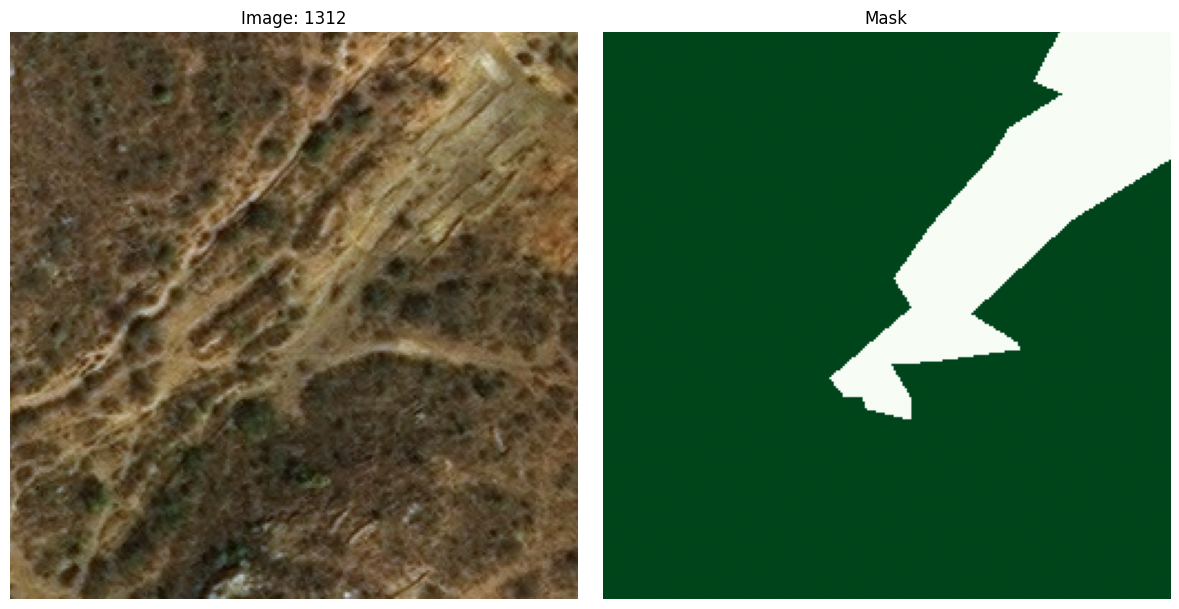

In [23]:


def visualize_random_sample(dataset):
    # visualize random sample
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    img_plot = image.permute(1, 2, 0).numpy()
    mask_plot = mask.squeeze().numpy()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_plot)
    plt.title(f"Image: {idx}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_plot, cmap='Greens') # 'Greens' o 'gray' para ver el contraste
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_sample(train_dataset)

In [20]:
!cp -r "/content/drive/MyDrive/FOREST/Forest Segmented/Forest Segmented/." /content/dataset_local/

In [25]:
num_epochs = 20
best_iou = 0.0  # Para guardar el mejor modelo basado en precisión

for epoch in range(num_epochs):
    print("We're now in epoch", epoch+1)
    model.train()
    train_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    #validate after epoch
    model.eval()
    val_loss = 0
    total_iou = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # loss
            v_loss = criterion(outputs, masks)
            val_loss += v_loss.item()

            # iou
            tp, fp, fn, tn = smp.metrics.get_stats((outputs > 0.5).long(), masks.long(), mode='binary')
            iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            total_iou += iou

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = total_iou / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_iou:.4f}")

    # save if best
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), 'best_forest_model.pth')
        print(f"IoU record reached! Model saved.")
    print("-" * 30)

print("Training ended.")

We're now in epoch 1
Epoch [1/20]
  Train Loss: 0.3416 | Val Loss: 0.3318 | Val IoU: 0.7550
IoU record reached! Model saved.
------------------------------
We're now in epoch 2
Epoch [2/20]
  Train Loss: 0.3255 | Val Loss: 0.3306 | Val IoU: 0.7527
------------------------------
We're now in epoch 3
Epoch [3/20]
  Train Loss: 0.3205 | Val Loss: 0.3242 | Val IoU: 0.7584
IoU record reached! Model saved.
------------------------------
We're now in epoch 4
Epoch [4/20]
  Train Loss: 0.3186 | Val Loss: 0.3231 | Val IoU: 0.7624
IoU record reached! Model saved.
------------------------------
We're now in epoch 5
Epoch [5/20]
  Train Loss: 0.3172 | Val Loss: 0.3245 | Val IoU: 0.7552
------------------------------
We're now in epoch 6
Epoch [6/20]
  Train Loss: 0.3158 | Val Loss: 0.3234 | Val IoU: 0.7576
------------------------------
We're now in epoch 7
Epoch [7/20]
  Train Loss: 0.3153 | Val Loss: 0.3263 | Val IoU: 0.7471
------------------------------
We're now in epoch 8
Epoch [8/20]
  Trai

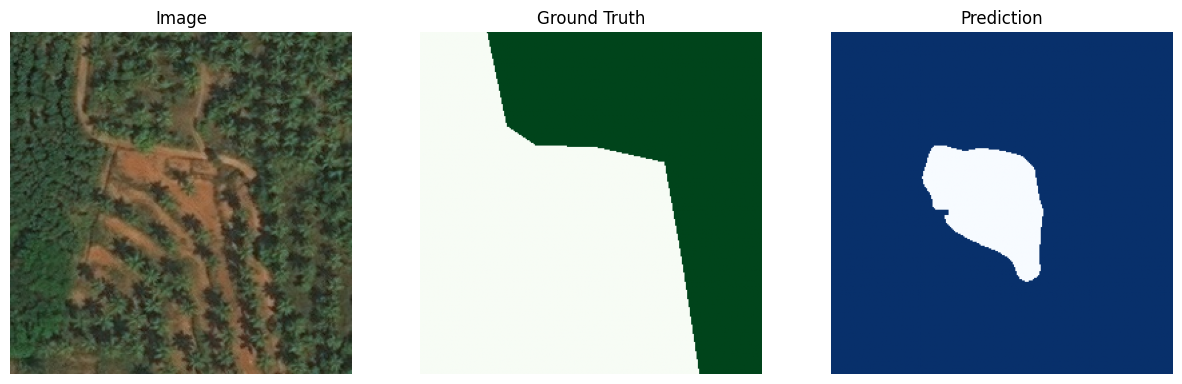

In [40]:
def test_prediction(dataset, model, device):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    # Preparar imagen para el modelo (añadir dimensión de batch)
    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        # Convertir probabilidad a máscara binaria (umbral 0.5)
        pred_mask = (output > 0.5).float().cpu().squeeze().numpy()

    # Preparar para graficar
    img_plot = image.permute(1, 2, 0).numpy()
    true_mask = mask.squeeze().numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_plot)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='Greens')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='Blues')
    plt.title("Prediction")
    plt.axis('off')

    plt.show()

# Cargar el mejor modelo antes de probar
model.load_state_dict(torch.load('best_forest_model.pth'))
test_prediction(val_dataset, model, device)

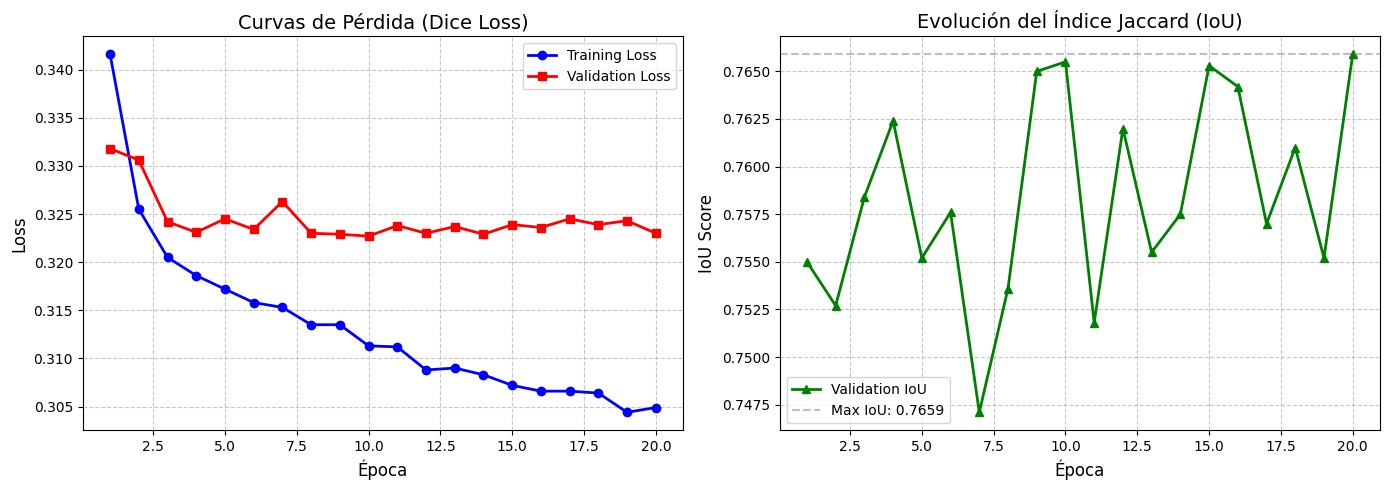

In [32]:
import matplotlib.pyplot as plt

# --- DATOS EXTRAÍDOS DE TUS LOGS ---
epochs = list(range(1, 21))

train_loss = [
    0.3416, 0.3255, 0.3205, 0.3186, 0.3172, 0.3158, 0.3153, 0.3135, 0.3135, 0.3113,
    0.3112, 0.3088, 0.3090, 0.3083, 0.3072, 0.3066, 0.3066, 0.3064, 0.3044, 0.3049
]

val_loss = [
    0.3318, 0.3306, 0.3242, 0.3231, 0.3245, 0.3234, 0.3263, 0.3230, 0.3229, 0.3227,
    0.3238, 0.3230, 0.3237, 0.3229, 0.3239, 0.3236, 0.3245, 0.3239, 0.3243, 0.3230
]

val_iou = [
    0.7550, 0.7527, 0.7584, 0.7624, 0.7552, 0.7576, 0.7471, 0.7536, 0.7650, 0.7655,
    0.7518, 0.7620, 0.7555, 0.7575, 0.7653, 0.7642, 0.7570, 0.7610, 0.7552, 0.7659
]

# --- CREACIÓN DEL GRÁFICO ---
plt.figure(figsize=(14, 5))

# Subplot 1: Curvas de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-ono', label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, 'r-s', label='Validation Loss', linewidth=2)
plt.title('Curvas de Pérdida (Dice Loss)', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Subplot 2: Evolución de la Métrica IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, val_iou, 'g-^', label='Validation IoU', linewidth=2)
plt.axhline(y=max(val_iou), color='gray', linestyle='--', alpha=0.5, label=f'Max IoU: {max(val_iou):.4f}')
plt.title('Evolución del Índice Jaccard (IoU)', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('IoU Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('reporte_entrenamiento_unet.png', dpi=300) # Guarda el gráfico en alta calidad
plt.show()